# 09. Primera optimización de hiper-parámetros: Optimización del punto de corte

### Algunas cosas para leer

#### ¿Qué es la optimización de hiper-parámetros?
https://en.wikipedia.org/wiki/Hyperparameter_optimization

#### ¿Qué es grid search?
https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search

#### ¿Qué es optimización bayesiana?
https://en.wikipedia.org/wiki/Bayesian_optimization

## Importamos paquetes necesarios

In [14]:
import pandas as pd
import numpy as np
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

from IPython.display import Image  

import graphviz_tools as agt
import mlflow_utils as a_mlflow_u
import tree_utils as atu

## Cargamos nuestros dataset

In [15]:
file_cervezas_unicas_resumen_valores_con_clase_training = 'dataset/cervezas_unicas_resumen_valores_con_clase_train.csv'
file_cervezas_unicas_resumen_valores_con_clase_testing = 'dataset/cervezas_unicas_resumen_valores_con_clase_test.csv'

campos = ['beer_abv', 'review_aroma', 'review_appearance', 'review_taste', 'review_overall', 'review_palate', 'es_popular']

df_training_validacion = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_training)
df_testing = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_testing)

df_training_validacion = df_training_validacion.loc[:, campos]
df_testing = df_testing.loc[:, campos]

df_training_validacion.head()

,beer_abv,review_aroma,review_appearance,review_taste,review_overall,review_palate,es_popular
0,6.0,3.564000,3.736000,3.592000,3.776000,3.620000,NO
1,4.5,2.608108,3.351351,2.743243,2.945946,3.054054,NO
2,4.4,3.727273,3.727273,3.545455,3.545455,3.545455,NO
3,7.5,3.750000,3.500000,3.750000,3.750000,4.000000,NO
4,7.8,2.500000,3.500000,3.500000,3.500000,3.500000,NO


## Separamos en training y validacion

In [16]:
random_state = 1
test_size = 0.3

atributos = ['beer_abv', 'review_aroma', 'review_appearance', 'review_taste', 'review_overall', 'review_palate']
clase = ['es_popular']

Y_df_training_validacion = df_training_validacion.loc[:, clase]
df_training_validacion = df_training_validacion.loc[:, atributos]

X_train, X_validacion, Y_train, Y_validacion = train_test_split(
    df_training_validacion, 
    Y_df_training_validacion, 
    test_size=test_size, 
    random_state=random_state
)

### Tambien abrimos en X e Y el dataset de testing

In [17]:
X_testing = df_testing.loc[:, atributos]
Y_testing = df_testing.loc[:, clase]

### Modelo con el nuevo dataset

In [18]:
max_depth = 4
criterion='gini'
clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth=max_depth,
            random_state=1
        )
_ = clf.fit(X_train, Y_train)

### Grid search

In [19]:
resultados = []

Y_validacion_pred = clf.predict_proba(X_validacion)
df_y_validacion_pred_proba = pd.DataFrame(Y_validacion_pred, columns = ['NO_prob', 'SI_prob'])

for umbral_corte in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    
    y_validacion_pred = atu.evaluar_corte(df_y_validacion_pred_proba['NO_prob'].values, umbral_corte, 'SI', 'NO')
    
    resultado = atu.calcular_metricas(
        y_true=Y_validacion['es_popular'].values, 
        y_pred = y_validacion_pred, 
        labels = ['NO', 'SI'])
    resultados.append([umbral_corte, resultado['metrica negocio']])
    
resultados

[[0.0, -0.3952569169960474],
 [0.1, -0.3952569169960474],
 [0.2, -0.3952569169960474],
 [0.3, -0.3952569169960474],
 [0.4, -0.3952569169960474],
 [0.5, 5.533596837944664],
 [0.6, 5.533596837944664],
 [0.7, 107.5098814229249],
 [0.8, 578.6561264822135],
 [0.9, 1850.592885375494],
 [1, 131.62055335968378]]

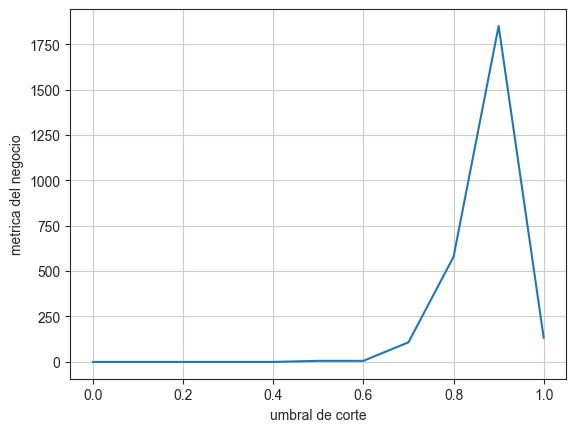

In [32]:
sns.set_style("ticks",{'axes.grid' : True})

chart_df = pd.DataFrame(data = resultados, columns=['x', 'y'])
g1 = sns.lineplot(data=chart_df, x="x", y="y")
g1.set(xlabel='umbral de corte', ylabel='metrica del negocio')
plt.show()

#### Optimización bayesiana

In [21]:
def f(umbral_corte):
    y_validacion_pred = atu.evaluar_corte(df_y_validacion_pred_proba['NO_prob'].values, umbral_corte, 'SI', 'NO')
    
    resultado = atu.calcular_metricas(
        y_true = Y_validacion['es_popular'].values, 
        y_pred = y_validacion_pred, 
        labels = ['NO', 'SI'])
    return -resultado['metrica negocio']

In [22]:
space  = [
    Real(0.00001, 0.99999, name='umbral_corte')
]

res = gp_minimize(f,                  # the function to minimize
                  space,     # the bounds on each dimension of x
                  n_initial_points = 10,
                  n_calls=50,         # the number of evaluations of f including at x0
                  n_random_starts=10,  # the number of random initialization points
                  random_state=777,
                  callback = lambda res: print([
                          len(res.func_vals), 
                          res.x_iters[len(res.x_iters)-1], 
                          -res.func_vals[len(res.func_vals)-1]
                      ])
                 )

[1, [0.6464468254096104], 107.5098814229249]
[2, [0.6464468254096104], 107.5098814229249]
[3, [0.6464468254096104], 107.5098814229249]
[4, [0.6464468254096104], 107.5098814229249]
[5, [0.6464468254096104], 107.5098814229249]
[6, [0.6464468254096104], 107.5098814229249]
[7, [0.6464468254096104], 107.5098814229249]
[8, [0.8827650977031866], 800.0]
[9, [0.8827650977031866], 800.0]
[10, [0.8827650977031866], 800.0]
[11, [0.95273898410968], 1917.7865612648222]
[12, [0.95273898410968], 1917.7865612648222]
[13, [0.95273898410968], 1917.7865612648222]
[14, [0.95273898410968], 1917.7865612648222]
[15, [0.95273898410968], 1917.7865612648222]
[16, [0.95273898410968], 1917.7865612648222]
[17, [0.95273898410968], 1917.7865612648222]
[18, [0.95273898410968], 1917.7865612648222]
[19, [0.95273898410968], 1917.7865612648222]
[20, [0.95273898410968], 1917.7865612648222]
[21, [0.95273898410968], 1917.7865612648222]
[22, [0.95273898410968], 1917.7865612648222]
[23, [0.95273898410968], 1917.7865612648222]


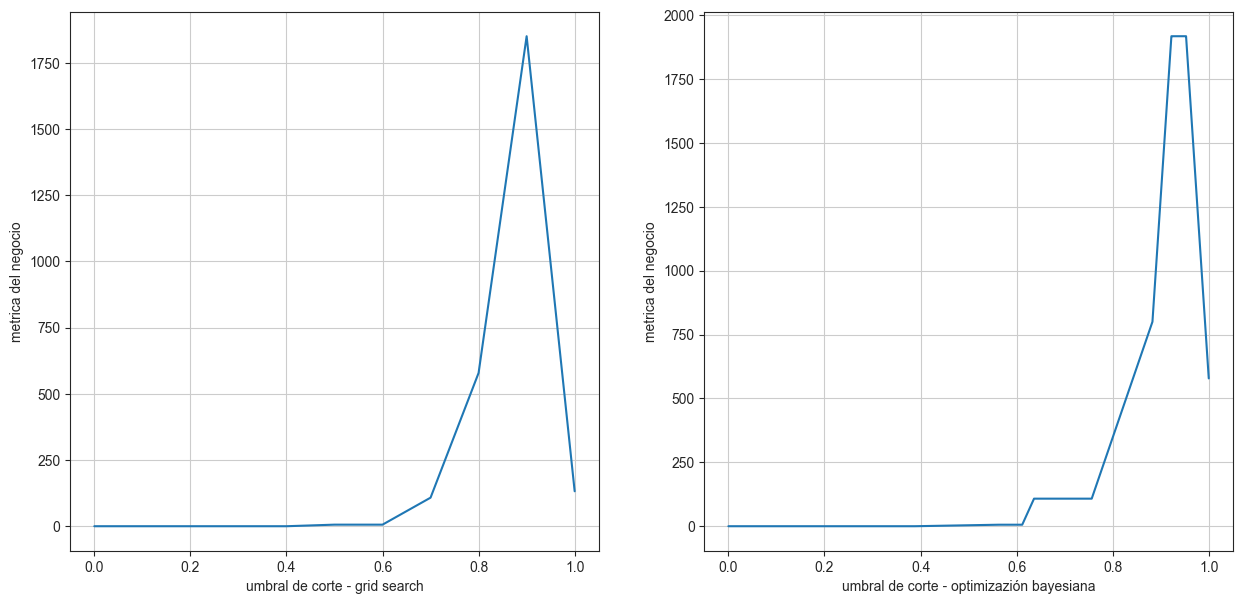

In [33]:
chart_df_bo = pd.DataFrame(data = np.array(res.x_iters).reshape(1, -1)[0], columns=['x'])
chart_df_bo['y'] = -res.func_vals 

fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(15, 7))

g1 = sns.lineplot(data=chart_df_bo, x="x", y="y", ax=ax2)
g1.set(xlabel='umbral de corte - optimizazión bayesiana', ylabel='metrica del negocio')

g1 = sns.lineplot(data=chart_df, x="x", y="y", ax=ax1)
g1.set(xlabel='umbral de corte - grid search', ylabel='metrica del negocio')

plt.show()

In [11]:
[res.x, -res.fun]

[[0.95273898410968], 1917.7865612648222]

### Probamos el umbral en validacion (ya lo probamos.. pero lo vamos a registrar)

In [34]:
umbral_corte = res.x

y_validacion_pred = clf.predict_proba(X_validacion)

df_y_validacion_pred_proba = pd.DataFrame(y_validacion_pred, columns = ['NO_prob', 'SI_prob'])

y_validacion_pred = atu.evaluar_corte(df_y_validacion_pred_proba['NO_prob'].values, umbral_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_validacion['es_popular'].values, 
    y_pred = y_validacion_pred, 
    labels=['NO', 'SI']
)

parametros = {
    'max_depth' : max_depth,
    'umbral_corte' : umbral_corte
}
    
[metricas, parametros]

[{'true negatives': 7359,
  'true positives': 364,
  'false positives': 2428,
  'false negatives': 142,
  'accuracy': 0.7503,
  'recall': 0.7194,
  'precision': 0.1304,
  'specificity': 0.7519,
  'tasa falso positivo': 0.2481,
  'tasa falso negativo': 0.0145,
  'f1': 0.2207,
  'metrica negocio': 1917.7865612648222,
  'metrica optima negocio': 4000.0},
 {'max_depth': 4, 'umbral_corte': [0.95273898410968]}]

In [35]:
a_mlflow_u.log_experimento(
    host = 'http://localhost:5000', 
    nombre_experimento="AnalisisDeCervezas", 
    run_name="Tercera ejecucion", 
    descripcion="Rpart con umbral de corte modificado utilizando optimización gausiana", 
    dataset_tag="validacion", 
    parametros=parametros, 
    metricas=metricas,
    model=clf, 
    artifact_path="model"
)

C:\Users\arouiller\AppData\Local\miniconda3\envs\python_3_9_beer_analysis\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Probamos el umbral de corte en testing

In [36]:
umbral_corte = res.x[0]
y_testing_pred = clf.predict_proba(X_testing)

df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])

y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_testing['es_popular'].values, 
    y_pred = y_testing_pred, 
    labels=['NO', 'SI']
)

metricas['max_depth'] = max_depth
metricas['umbral_corte'] = umbral_corte
    
parametros = {
    'max_depth' : max_depth,
    'umbral_corte' : umbral_corte
}
    
[metricas, parametros]

[{'true negatives': 10555,
  'true positives': 549,
  'false positives': 3411,
  'false negatives': 189,
  'accuracy': 0.7552,
  'recall': 0.7439,
  'precision': 0.1386,
  'specificity': 0.7558,
  'tasa falso positivo': 0.2442,
  'tasa falso negativo': 0.0135,
  'f1': 0.2337,
  'metrica negocio': 2051.2195121951218,
  'metrica optima negocio': 4000.0,
  'max_depth': 4,
  'umbral_corte': 0.95273898410968},
 {'max_depth': 4, 'umbral_corte': 0.95273898410968}]

In [37]:
a_mlflow_u.log_experimento(
    host = 'http://localhost:5000', 
    nombre_experimento="AnalisisDeCervezas", 
    run_name="Tercera ejecucion", 
    descripcion="Rpart con umbral de corte modificado utilizando optimización gausiana", 
    dataset_tag="testing", 
    parametros=parametros, 
    metricas=metricas,
    model=clf, 
    artifact_path="model"
)